In [ ]:
#Step 1 Load the Data

# Time Series Forecasting - Multivariate Time Series Models for Crypto Order Book Market Prediction

import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline

pyo.init_notebook_mode()

import math # Mathematical functions
import numpy as np # Fundamental package for scientific computing with Python
import seaborn as sns # Visualization
import pandas as pd # Additional functions for analysing and manipulating data
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
from scipy import stats

# import matplotlib.dates as mdates # Formatting dates
# from datetime import date, timedelta, datetime # Date Functions
# from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates

sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 60

# List of considered Features
FEATURES = ['av_ask', 'av_bid', 'p_zoomed', 'da_zoomed', 'db_zoomed']

# The dictionary of dataframes for different timeranges
superdf = {}
TRAIN = {'X': {}, 'Y': {}}
TEST = {'X': {}, 'Y': {}}
scalers = {}

df = pd.read_csv('../data/20220928.csv')
df = df[df['symbol'].str.contains("BTC_USD")]
df = df[(np.abs(stats.zscore(df.select_dtypes(include=np.number))) < 3).all(axis=1)]
df.ts = pd.to_datetime(df.ts)

print('OK - data loaded successfully')

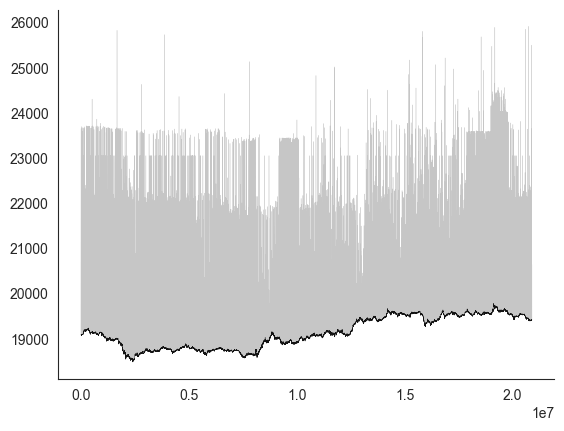

In [72]:
from scipy.ndimage import median_filter

x = df.copy()
x.ask_price = median_filter(df.ask_price, size=50)

plt.plot(np.arange(0, df.shape[0]), df['ask_price'], '-', color="silver", alpha=0.9, linewidth=0.25)
plt.plot(np.arange(0, x.shape[0]), x['ask_price'], '-', color="black", alpha=0.9, linewidth=0.25)
plt.show()


In [73]:
# df = df.head(5000)
df.info()


# df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20896831 entries, 0 to 21664464
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             object        
 1   symbol         object        
 2   sequence       float64       
 3   ask_price      float64       
 4   ask_size       float64       
 5   bid_price      float64       
 6   bid_size       float64       
 7   time_coinapi   object        
 8   time_exchange  object        
 9   ts             datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 1.7+ GB


In [74]:
# timeranges = ['1.0S', '2.0S', '3.0S', '4.0S', '5.0S', '6.0S', '7.0S', '8.0S', '9.0S', '10.0S', '15.0S', '20.0S', '25.0S', '30.0S']
# timeranges = ['0.5S', '1.0S', '1.5S', '3.0S', '5.0S', '30S', '3T']
timeranges = ['1.0S', '2.0S', '4.0S', '8.0S', '16.0S', '32.0S']
# timeranges = ['0.5S', '1.0S', '1.5S', '3.0S', '5.0S']
# timeranges = ['0.5S', '1.0S', '1.5S', '3.0S']
# timeranges = ['0.5S', '1.0S', '1.5S']
# timeranges = ['0.1S', '0.5S', '1.0S']
# timeranges = ['30.0S']

print(len(df))

# set the indextimestamp
# df.index = df.time_coinapi
def get_data(datasource, timerange):
    datasource = datasource.drop(columns=['time_coinapi', 'time_exchange', 'id', 'symbol', 'sequence'])
    datasource['pressure_ask'] = datasource['ask_price'] * datasource ['ask_size']
    datasource['pressure_bid'] = datasource['bid_price'] * datasource ['bid_size']
    datasource['ts'] = pd.to_datetime(datasource['ts'])
    datasource = datasource.set_index('ts')
    datasource.sort_values(by=['ts'])
    datasource = datasource.resample(timerange).sum()
    datasource['av_ask'] = datasource['pressure_ask'] / datasource['ask_size']
    datasource['av_bid'] = datasource['pressure_bid'] / datasource['bid_size']
    datasource['p_zoomed'] = (datasource['pressure_ask'] + datasource['pressure_bid'] ) / (datasource['ask_size'] + datasource['bid_size'])
    datasource['da_zoomed'] = abs(datasource['p_zoomed'] - datasource['av_ask'])
    datasource['db_zoomed'] = abs(datasource['p_zoomed'] - datasource['av_bid'])
    datasource.fillna(method="ffill", inplace=True)
    datasource.fillna(method="bfill", inplace=True)
    datasource.fillna(0, inplace=True)
    return datasource


20896831


In [75]:
def load_data(datasource, timeranges):
    for i in range(0, len(timeranges)):
        superdf[timeranges[i]] = get_data(datasource, timeranges[i])

load_data(df, timeranges)

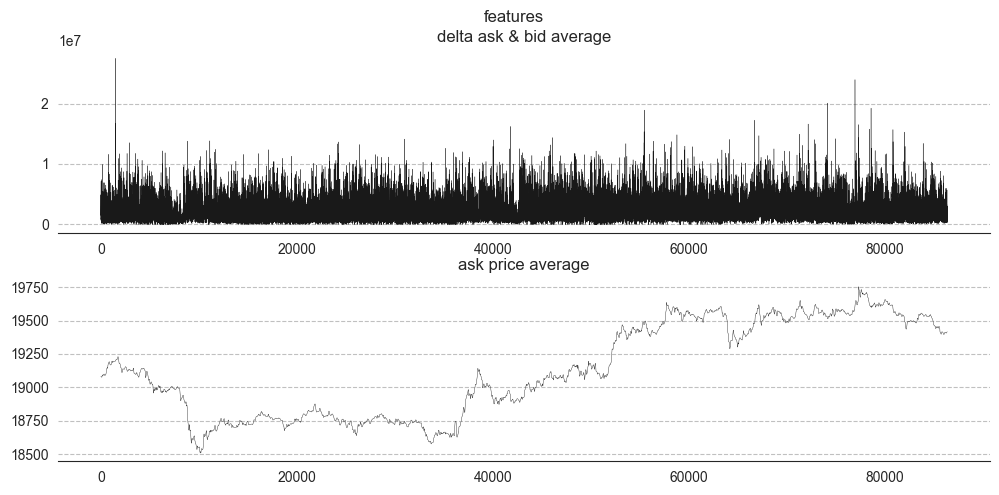

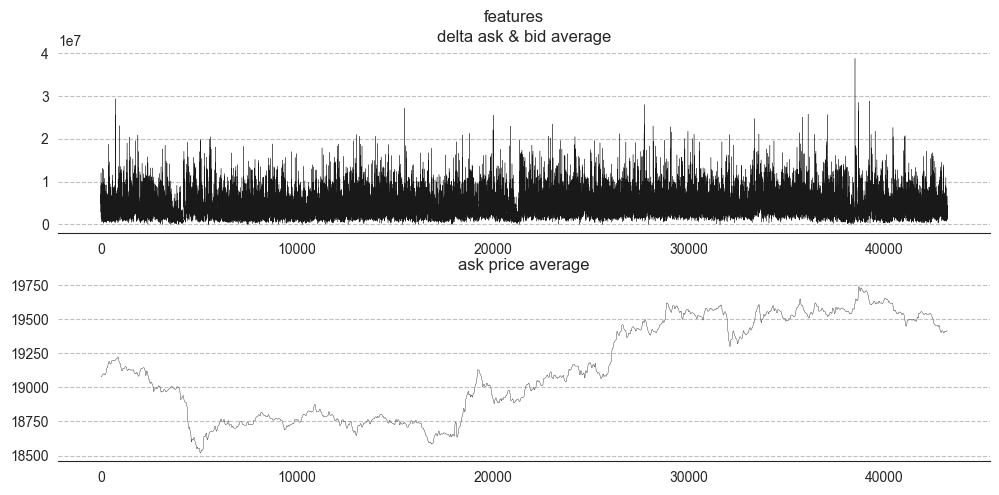

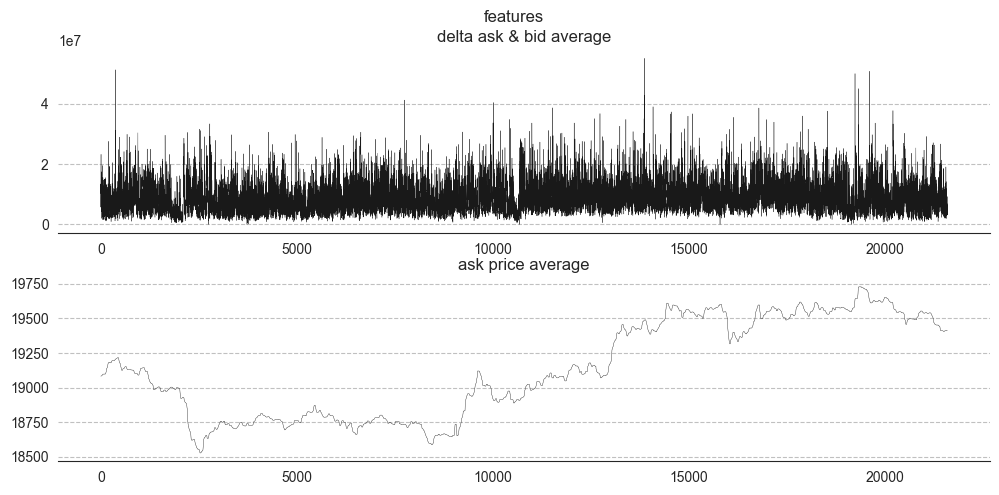

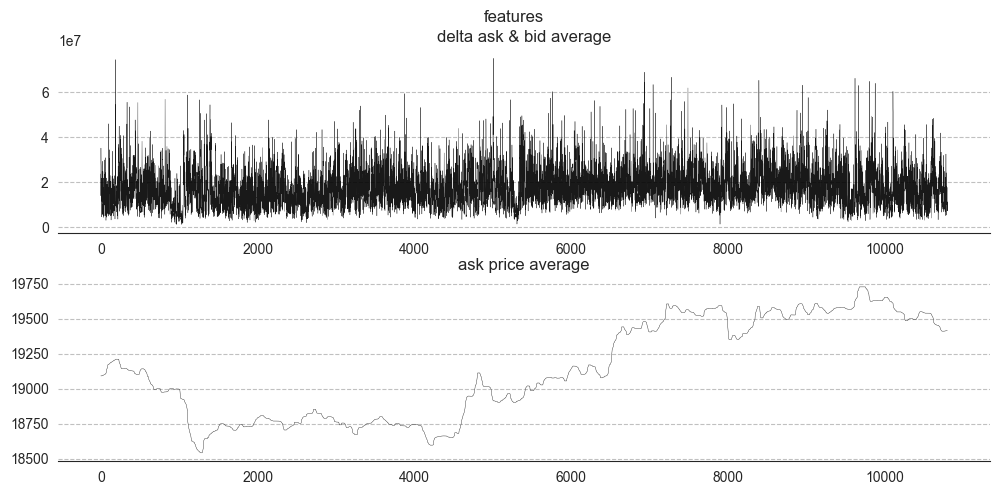

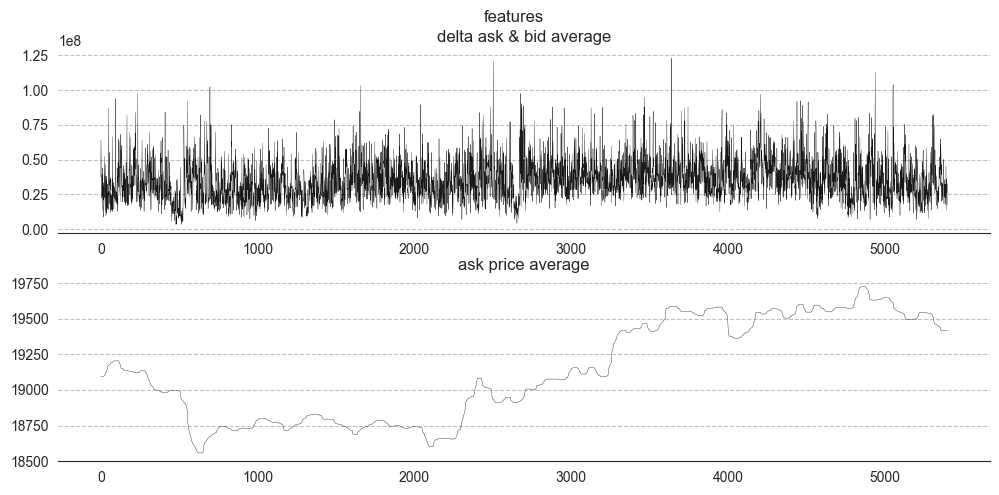

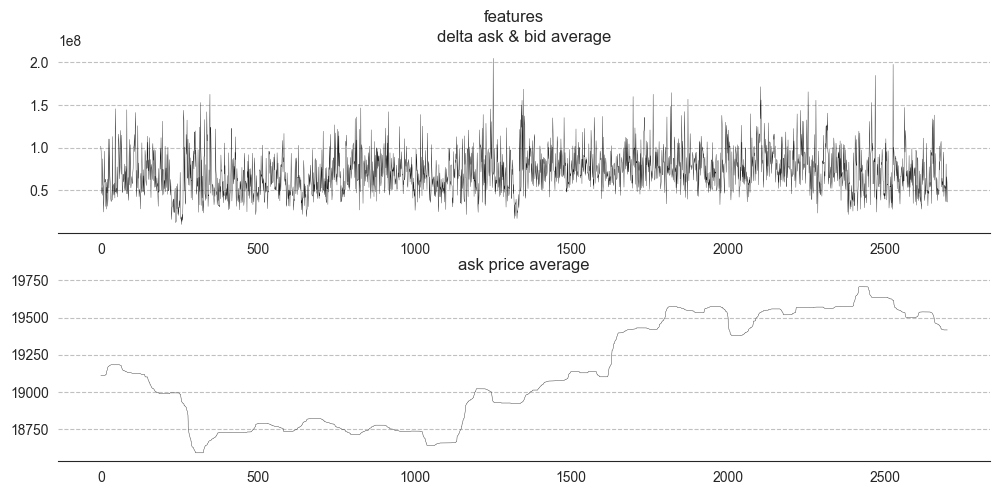

In [80]:
def visualize_data(datasource):
    fig, (sp1, sp2) = plt.subplots(2, 1, figsize=(10, 5))
    fig.suptitle('features')

    sp1.spines['top'].set_visible(False)
    sp1.spines['right'].set_visible(False)
    sp1.spines['left'].set_visible(False)
    sp1.grid(axis='y', color='silver', linestyle='--', linewidth=0.8)

    sp2.spines['top'].set_visible(False)
    sp2.spines['right'].set_visible(False)
    sp2.spines['left'].set_visible(False)
    sp2.grid(axis='y', color='silver', linestyle='--', linewidth=0.8)

    sp1.title.set_text('delta ask & bid average')
    sp2.title.set_text('ask price average')
    fig.tight_layout()
    fig.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)

    x = datasource.copy()
    x.av_ask = median_filter(datasource.av_ask, size=50)

    sp1.plot(np.arange(0, datasource.shape[0]), datasource.pressure_ask, '-', color="black", alpha=0.9, linewidth=0.25)
    sp2.plot(np.arange(0, datasource.shape[0]), datasource.av_ask, '-', color="silver", alpha=0.9, linewidth=0.15)
    sp2.plot(np.arange(0, datasource.shape[0]), x.av_ask, '-', color="black", alpha=0.9, linewidth=0.25)

    # plt.savefig(name + '.png', dpi=1200)
    plt.show()

def prepare_data(datasource, sequence_len): #data_filtered
    filtered = datasource[FEATURES]

    # Convert the data to numpy values
    np_data_unscaled = np.array(filtered)

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
    scaler_pred = MinMaxScaler()
    scaler_da = MinMaxScaler()
    scaler_db = MinMaxScaler()

    predicted_price = pd.DataFrame(filtered['p_zoomed'])
    da = pd.DataFrame(filtered['da_zoomed'])
    db = pd.DataFrame(filtered['db_zoomed'])

    np_data_scaled = scaler.fit_transform(np_data_unscaled)
    scaler_pred.fit_transform(predicted_price)
    scaler_da.fit_transform(da)
    scaler_db.fit_transform(db)

    # Split the training data into train and train data sets
    # As a first step, we get the number of rows to train the model on 80% of the data
    train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

    # Create the training and test data
    tr_data = np_data_scaled[0:train_data_len, :]
    ts_data = np_data_scaled[train_data_len - sequence_len:, :]

    scalers = [scaler, scaler_pred, scaler_da, scaler_db]

    #Step 3 Preprocessing and Feature Selection

    # Indexing Batches
    # train_df = datasource.sort_values(by=['ts']).copy()
    train_df = datasource.head(20000)

    # Prediction Index
    index_mid_price = pd.DataFrame(train_df)[FEATURES].columns.get_loc("p_zoomed")
    index_ask_delta = pd.DataFrame(train_df)[FEATURES].columns.get_loc("da_zoomed")
    index_bid_delta = pd.DataFrame(train_df)[FEATURES].columns.get_loc("db_zoomed")

    # The RNN needs data with the format of [samples, time steps, features]
    # Here, we create N samples, sequence_length time steps per sample, and 6 features
    def partition_dataset(sequence_length, datasource):
        x, y = [], []
        data_len = datasource.shape[0]
        for i in range(sequence_length, data_len):
            x.append(datasource[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
            y.append([datasource[i, index_mid_price], datasource[i, index_ask_delta], datasource[i, index_bid_delta]]) #contains the prediction values for validation,  for single-step prediction

        # Convert the x and y to numpy arrays
        x = np.array(x)
        y = np.array(y)
        return x, y

    # Generate training data and test data
    x_train, y_train = partition_dataset(sequence_len, tr_data)
    x_test, y_test = partition_dataset(sequence_len, ts_data)

    return x_train, y_train, x_test, y_test, scalers

x = superdf.copy()

for i in range(0, len(timeranges)):
    x[timeranges[i]].av_ask = median_filter(superdf[timeranges[i]].av_ask, size=50)
    visualize_data(superdf[timeranges[i]])

In [81]:
# Create training and test sets
# timeranges = ['7.0S', '8.0S']

for i in range(0, len(timeranges)):
    TRAIN['X'][timeranges[i]],\
    TRAIN['Y'][timeranges[i]],\
    TEST['X'][timeranges[i]],\
    TEST['Y'][timeranges[i]],\
    scalers[timeranges[i]]\
                    = prepare_data(x[timeranges[i]].tail(10000), sequence_length)

print(scalers)

{'30.0S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '0.1S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '0.5S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '1.0S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '1.5S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '3.0S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '5.0S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '30S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '2.0S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '4.0S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '8.0S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '16.0S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()], '32.0S': [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()]}


In [82]:
#Step 4 Model Configuration

models = {}

def build_model(input_shape, iterator):
    neurons = {}
    model = None
    model = Sequential()
    neurons[iterator] = TRAIN['X'][timeranges[i]].shape[1] * TRAIN['X'][timeranges[i]].shape[2]
    model.add(LSTM(neurons[iterator], return_sequences=True, input_shape=(TRAIN['X'][iterator].shape[1], TRAIN['X'][iterator].shape[2])))
    model.add(LSTM(neurons[iterator], return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(3))
    model.compile(optimizer='adam', loss='mse')
    return model

for i in range(0, len(timeranges)):
    models[timeranges[i]] = build_model((TRAIN['X'][timeranges[i]].shape[1], TRAIN['X'][timeranges[i]].shape[2]), timeranges[i])

# print(models)


training the model number 1 on the dataset with aggregation by 1.0S each step...
Epoch 1/2
159/159 [==============================] - 64s 386ms/step - loss: 0.0031 - val_loss: 8.3608e-04
Epoch 2/2
159/159 [==============================] - 65s 407ms/step - loss: 0.0017 - val_loss: 7.8411e-04


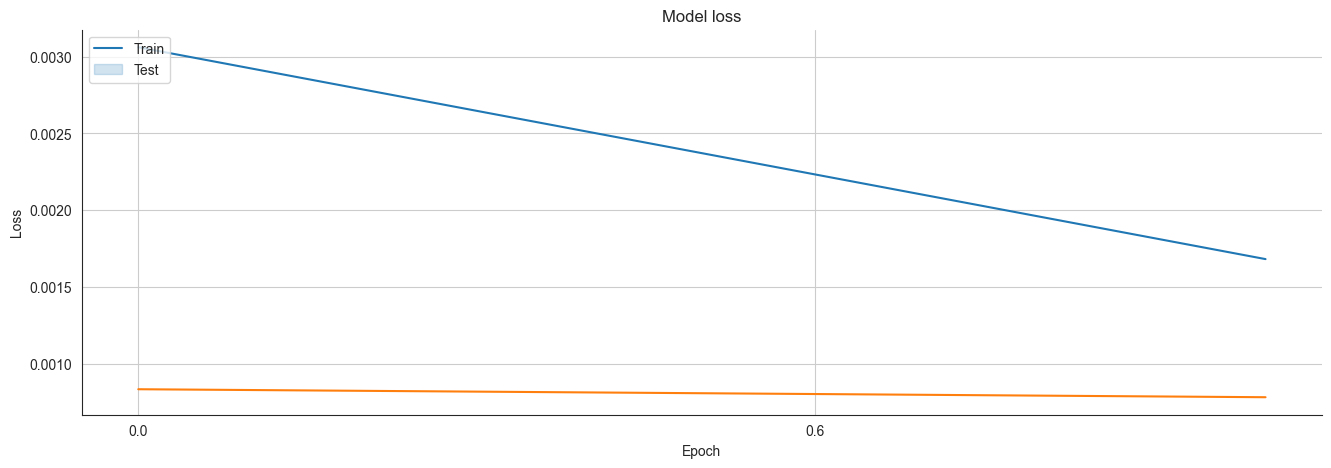

1/1 [==============================] - 0s 26ms/step
training of the model number 1 completed:
Median Absolute Error (MAE): 14.44
Mean Absolute Percentage Error (MAPE): 0.07 %
Median Absolute Percentage Error (MDAPE): 0.05 %

The last ask price is 19414.78
The predicted ask price is 19399.279296875 (-0.079903%)
Absolute error is +$15.500703124998836

The last bid price is 19411.8
The predicted bid price is 19390.759765625 (-0.108506%)
Absolute error is $21.040234374999272



training the model number 2 on the dataset with aggregation by 2.0S each step...
Epoch 1/2
159/159 [==============================] - 59s 358ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 2/2
159/159 [==============================] - 58s 362ms/step - loss: 0.0021 - val_loss: 0.0014


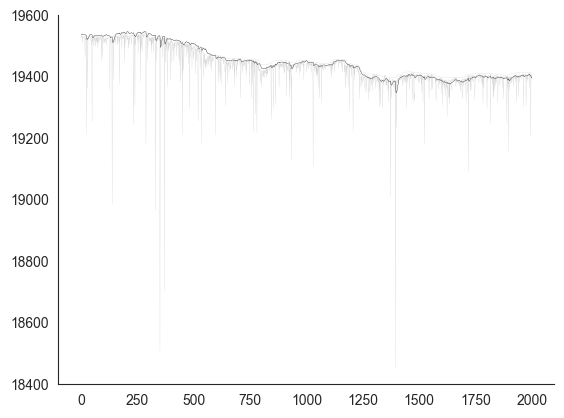

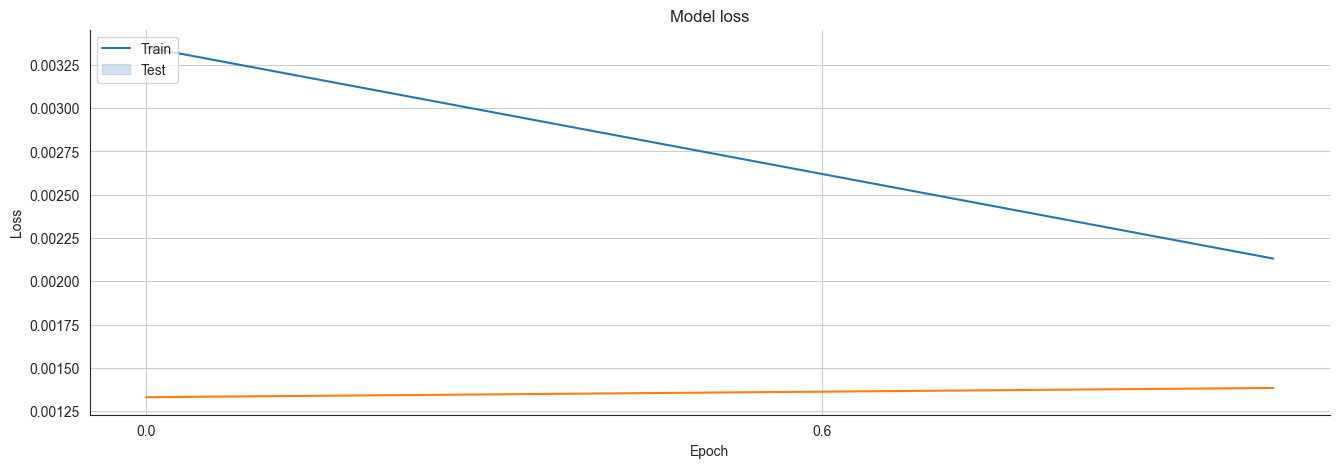

1/1 [==============================] - 0s 26ms/step
training of the model number 2 completed:
Median Absolute Error (MAE): 11.62
Mean Absolute Percentage Error (MAPE): 0.06 %
Median Absolute Percentage Error (MDAPE): 0.04 %

The last ask price is 19415.11
The predicted ask price is 19406.01953125 (-0.046844%)
Absolute error is +$9.090468750000582

The last bid price is 19407.14
The predicted bid price is 19399.6796875 (-0.038456%)
Absolute error is $7.460312499999418



training the model number 3 on the dataset with aggregation by 4.0S each step...
Epoch 1/2
159/159 [==============================] - 64s 384ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 2/2
159/159 [==============================] - 67s 419ms/step - loss: 0.0027 - val_loss: 0.0034


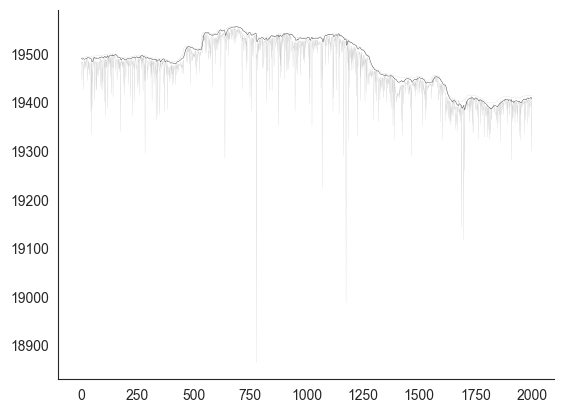

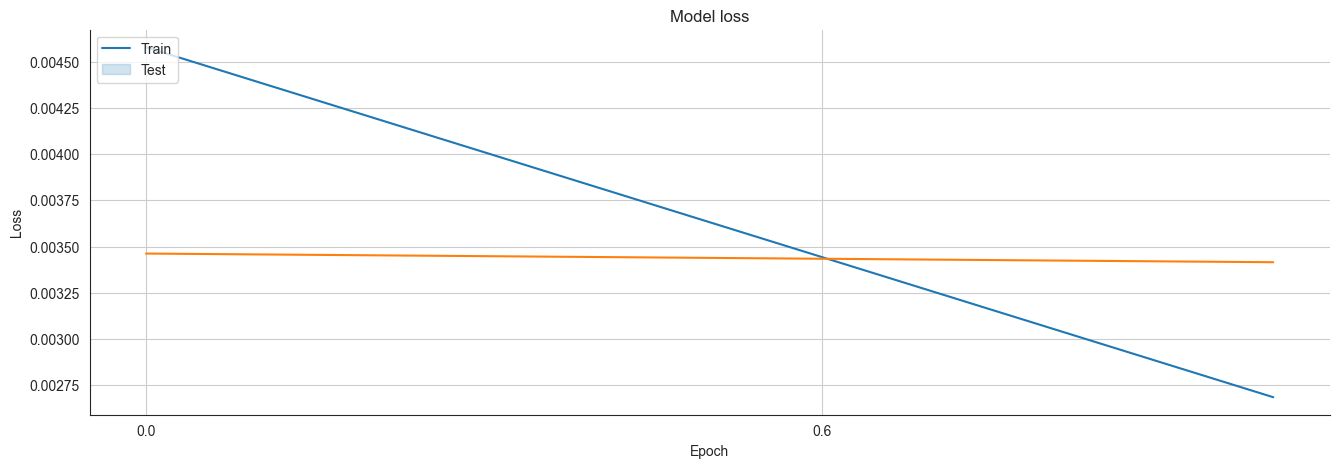

1/1 [==============================] - 0s 23ms/step
training of the model number 3 completed:
Median Absolute Error (MAE): 15.07
Mean Absolute Percentage Error (MAPE): 0.08 %
Median Absolute Percentage Error (MDAPE): 0.07 %

The last ask price is 19415.03
The predicted ask price is 19423.029296875 (+0.041185%)
Absolute error is $7.999296875001164

The last bid price is 19400.17
The predicted bid price is 19399.44921875 (-0.003715%)
Absolute error is $0.7207812499982538



training the model number 4 on the dataset with aggregation by 8.0S each step...
Epoch 1/2
159/159 [==============================] - 71s 433ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 2/2
159/159 [==============================] - 58s 363ms/step - loss: 0.0021 - val_loss: 0.0031


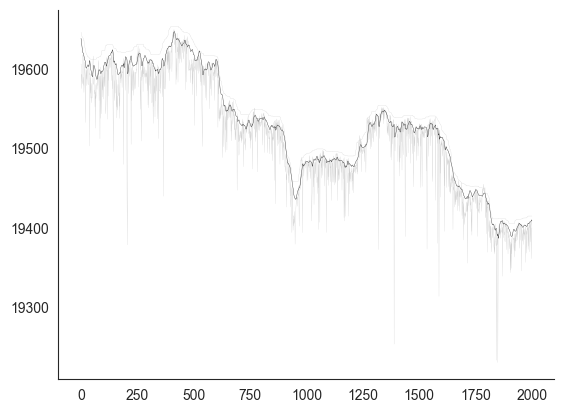

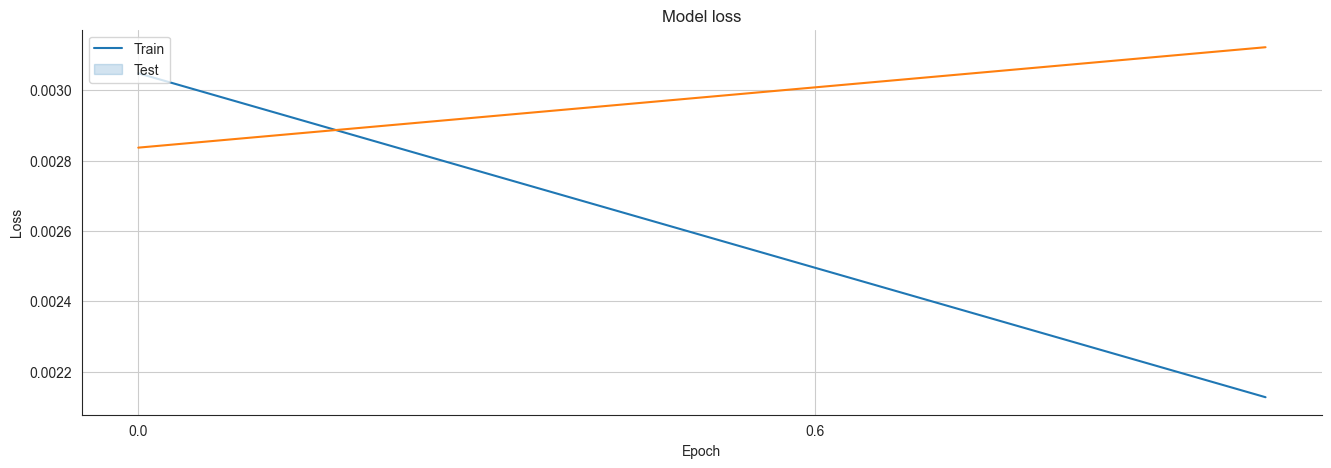

1/1 [==============================] - 0s 24ms/step
training of the model number 4 completed:
Median Absolute Error (MAE): 9.38
Mean Absolute Percentage Error (MAPE): 0.05 %
Median Absolute Percentage Error (MDAPE): 0.04 %

The last ask price is 19414.8
The predicted ask price is 19411.19921875 (-0.01855%)
Absolute error is +$3.6007812499992724

The last bid price is 19388.17
The predicted bid price is 19390.83984375 (+0.013769%)
Absolute error is +$2.6698437500017462



training the model number 5 on the dataset with aggregation by 16.0S each step...
Epoch 1/2
86/86 [==============================] - 34s 369ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 2/2
86/86 [==============================] - 30s 344ms/step - loss: 0.0030 - val_loss: 0.0047


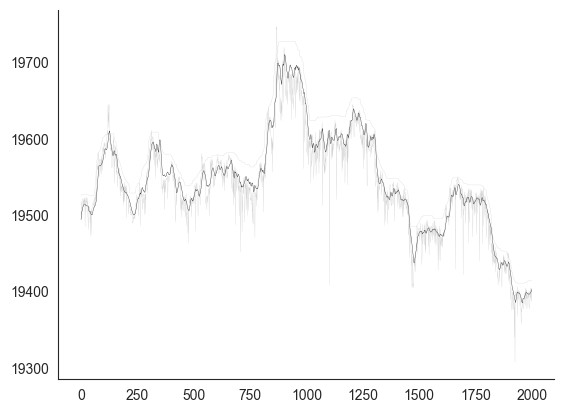

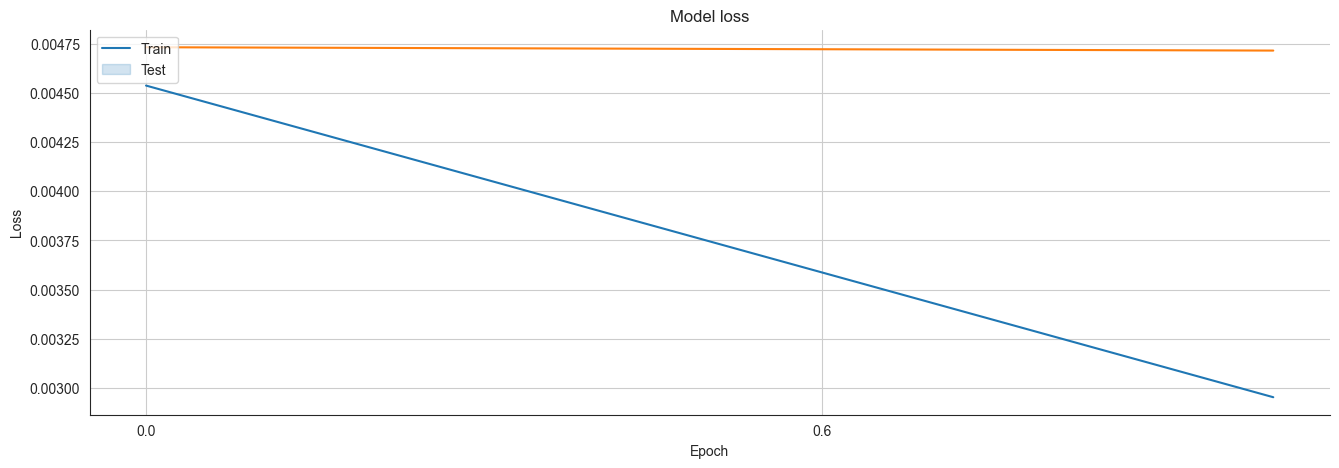

1/1 [==============================] - 0s 23ms/step
training of the model number 5 completed:
Median Absolute Error (MAE): 12.08
Mean Absolute Percentage Error (MAPE): 0.06 %
Median Absolute Percentage Error (MDAPE): 0.05 %

The last ask price is 19414.64
The predicted ask price is 19417.66015625 (+0.015554%)
Absolute error is $3.020156250000582

The last bid price is 19398.11
The predicted bid price is 19397.359375 (-0.00387%)
Absolute error is $0.7506250000005821



training the model number 6 on the dataset with aggregation by 32.0S each step...
Epoch 1/2
42/42 [==============================] - 16s 341ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 2/2
42/42 [==============================] - 14s 325ms/step - loss: 0.0040 - val_loss: 0.0061


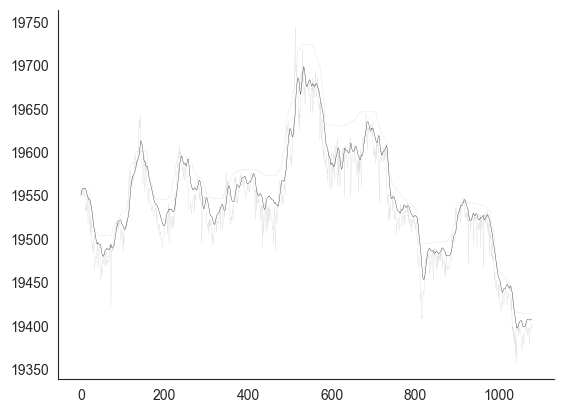

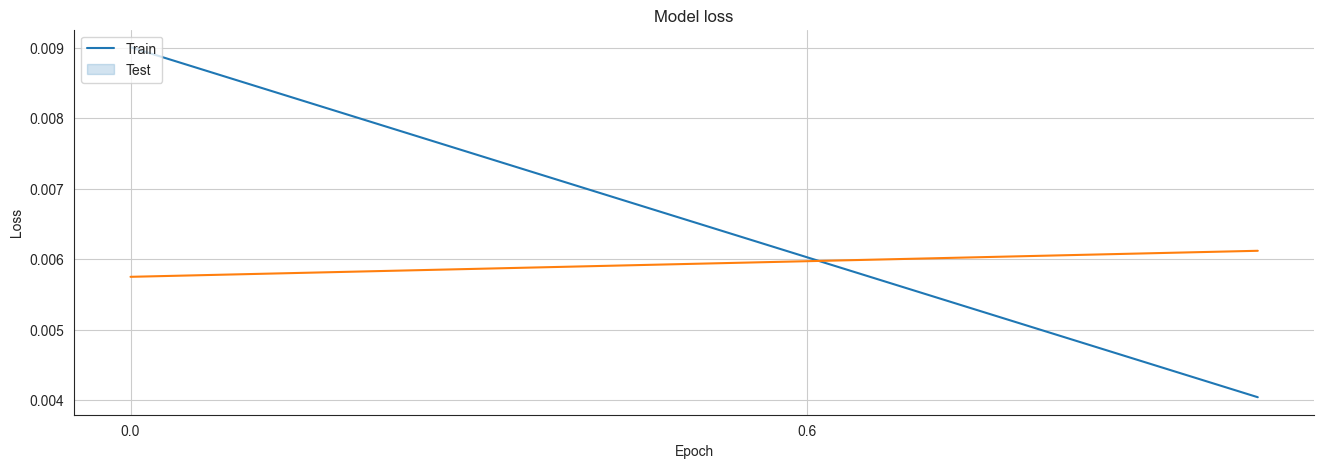

1/1 [==============================] - 0s 23ms/step
training of the model number 6 completed:
Median Absolute Error (MAE): 22.14
Mean Absolute Percentage Error (MAPE): 0.11 %
Median Absolute Percentage Error (MDAPE): 0.09 %

The last ask price is 19416.47
The predicted ask price is 19405.41015625 (-0.056994%)
Absolute error is +$11.059843750001164

The last bid price is 19400.6
The predicted bid price is 19385.529296875 (-0.077742%)
Absolute error is $15.070703124998545




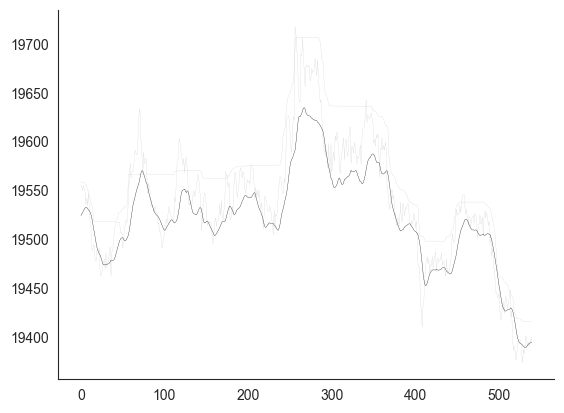

In [83]:
# Training the model
epochs = 2
batch_size = 50
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

# index = timeranges[1]

#main training cycle
for i in range(0, len(timeranges)):
    print(f'')
    print(f'='*50)
    print(f'training the model number {i+1} on the dataset with aggregation by {timeranges[i]} each step...')

    index = timeranges[i]

    history = models[index].fit(
                        TRAIN['X'][index],
                        TRAIN['Y'][index],
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(TEST['X'][index], TEST['Y'][index])
                       )

    fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
    sns.lineplot(data=history.history["loss"])
    sns.lineplot(data=history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Train", "Test"], loc="upper left")
    plt.grid()
    plt.show()

    # Get the predicted values
    prediction = models[index].predict(TEST['X'][index])

    # Unscale the predicted values
    pred_p =   scalers[index][1].inverse_transform(prediction[:, 0].reshape(-1,1))
    pred_da =  scalers[index][2].inverse_transform(prediction[:, 1].reshape(-1,1))
    pred_db =  scalers[index][3].inverse_transform(prediction[:, 2].reshape(-1,1))

    t = np.arange(0,pred_p.shape[0])

    plt.plot(t, superdf[index]['av_ask'][-pred_p.shape[0]:], '-', color="silver", alpha=0.9, linewidth=0.15)
    plt.plot(t, superdf[index]['av_bid'][-pred_p.shape[0]:], '-', color="silver", alpha=0.9, linewidth=0.15)
    plt.plot(t, pred_p, '-', color="black", alpha=0.9, linewidth=0.25)

    y_test_unscaled = scalers[index][1].inverse_transform(TEST['Y'][index][:, 0].reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled[:, 0], pred_p[:, 0] + pred_da[:, 0])
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled[:, 0], pred_p[:, 0] + pred_da[:, 0]) / y_test_unscaled[:, 0]))) * 100
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled[:, 0], pred_p[:, 0] + pred_da[:, 0]) / y_test_unscaled[:, 0])) ) * 100

    # Settings
    prediction_depth = 1 # mock for prediction depth
    counter = 0
    depth = 1 # accuracy validation depth, steps count
    error_margin = 0.5

    N = sequence_length

    train_df = pd.DataFrame(superdf[index])[FEATURES]
    new_df = train_df[- N - prediction_depth - 1:].filter(FEATURES)

    # Get the last N day closing price values and scale the data to be values between 0 and 1
    last_N_days = new_df[- N - (prediction_depth + 1): - prediction_depth - 1].values

    # Create an empty list and Append past N days
    X_test_new = [scalers[index][0].transform(last_N_days)]

    # Convert the X_test data set to a numpy array and reshape the data
    prediction = models[index].predict(np.array(X_test_new))

    # Unscale reshaped data into prediction values
    pred_p_unscaled = scalers[index][1].inverse_transform(prediction.reshape(-1, 1))[0]
    pred_da_unscaled = scalers[index][2].inverse_transform(prediction.reshape(-1, 1))[1]
    pred_db_unscaled = scalers[index][3].inverse_transform(prediction.reshape(-1, 1))[2]

    # Print last price and predicted price for the next day
    price_today = np.round(superdf[index]['av_ask'][-1], 2)
    predicted_price = np.round(pred_p[-1] + pred_da[-1], 2)[0]
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 6)

    plus = '+'; minus = ''
    print(f'training of the model number {i+1} completed:')
    print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    print(f'')

    print(f'The last ask price is {price_today}')
    print(f'The predicted ask price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')
    print(f'Absolute error is {plus if price_today - predicted_price > 0 else minus}${abs(price_today - predicted_price)}')
    print()

    price_today = np.round(new_df['av_bid'][-1], 2)
    predicted_price = np.round(pred_p_unscaled - pred_db_unscaled, 2)[0]
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 6)

    print(f'The last bid price is {price_today}')
    print(f'The predicted bid price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')
    print(f'Absolute error is {plus if price_today - predicted_price < 0 else minus}${abs(price_today - predicted_price)}')

    # tr = False
    #
    # for i in range (1, len(new_df) - depth):
    #     tr = False
    #     for j in range (0, depth):
    #         if (tr == False) and (new_df['av_ask'][i-1] + new_df['da_zoomed'][i]) > new_df['av_ask'][i + j] - error_margin:
    #             counter += 1
    #             tr = True
    #             break
    #
    # print(f'the accuracy of the ask price prediction within {depth} future ticks prediction horizon is {counter/(len(new_df) - depth - 1)} or {round(counter * 100/(len(new_df) - depth - 1), 2)}%')
    #
    # counter = 0
    # for i in range (1, len(new_df) - depth):
    #     tr = False
    #     for j in range (0, depth):
    #         if (tr == False) and (new_df['av_bid'][i-1] - new_df['db_zoomed'][i]) < new_df['av_bid'][i + j] + error_margin:
    #             counter += 1
    #             tr = True
    #             break
    # print(f'the accuracy of the bid price prediction within {depth} future ticks prediction horizon is {counter/(len(new_df) - depth - 1)} or {round(counter * 100/(len(new_df) - depth - 1), 2)}%')
    print(f'')
    print(f'')

#callbacks=[early_stop])